Here is an example of a pathway that may work for screening hepatotoxicants


This pathway: https://www.wikipathways.org/index.php/Pathway:WP2289

Is the Drug induction of bile acid pathway.

NOTE: could turn this into a networkX pathway and highlight nodes for a chemical based on activiation

In [2]:
# Could find GENE ids with the above PugREST URL,
# then need to map these to GeneIDs using PugREST

WIKI_PATHWAY = 'WP2289'

target_url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/gene/geneid/{}/summary/JSON'
pathway_url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/pathway/pwacc/wikipathways:{WIKI_PATHWAY}/geneids/TXT'

In [3]:
import requests, json
import pandas as pd


url = requests.get(pathway_url)
pathway_gene_ids = [f for f in url.text.split('\n') if f]

In [4]:
pathway_gene_ids

['570',
 '1244',
 '1576',
 '1581',
 '5243',
 '6554',
 '6822',
 '7421',
 '8647',
 '8714',
 '8856',
 '9970',
 '9971',
 '10257',
 '10599',
 '123264',
 '200931']

In [5]:
url = requests.get(target_url.format(','.join(pathway_gene_ids)))
text = url.text

data = json.loads(text)


Make a dictionary of all genes involved in pathway

In [6]:
targets_symbols2 = []
for s in data['GeneSummaries']['GeneSummary']:
    targets_symbols2.append((s['Symbol'], s['GeneID']))
t_mapper = pd.DataFrame(targets_symbols2, columns=['GeneSymbol', 'Gene IDs'])

In [7]:
t_mapper

,GeneSymbol,Gene IDs
0,BAAT,570
1,ABCC2,1244
2,CYP3A4,1576
3,CYP7A1,1581
4,ABCB1,5243
5,SLC10A1,6554
6,SULT2A1,6822
7,VDR,7421
8,ABCB11,8647
9,ABCC3,8714


In [8]:
print(f"There are {t_mapper.GeneSymbol.nunique()} Genes in this pathway")

There are 17 Genes in this pathway


Query the bioassays table to map gene IDs to PubChem Assays

In [9]:
import pandas as pd
import config
import numpy as np

#targets = pd.read_sql_query('select PUBCHEM_AID, GeneSymbol from targets WHERE GeneSymbol IS NOT NULL', con=config.Config.DB_URI)
targets = pd.read_sql_query('select AID, "Gene IDs", "Bioassay Name" from bioassays WHERE "Gene IDs" IS NOT NULL', con=config.Config.DB_URI)

Some assays have multiple targets.

In [10]:
targets['Gene IDs'] = targets['Gene IDs'].str.split('|')
targets = targets.explode('Gene IDs')
targets['Gene IDs'] = targets['Gene IDs'].astype(int)
targets

,AID,Gene IDs,BioAssay Name
0,361,58572631,Pyruvate Kinase
1,362,2357,Formylpeptide Receptor Ligand Binding Assay
2,365,946955,E. coli RNase H Inhibition
2,365,66671496,E. coli RNase H Inhibition
3,366,246243,human RNase H Inhibition
...,...,...,...
390698,1745839,5742,Cyclooxygenase COX-1 Eurofins-Panlabs enzyme a...
390699,1745840,5743,Cyclooxygenase COX-2 Eurofins-Panlabs enzyme a...
390700,1745841,246,Lipoxygenase 15-LO Eurofins-Panlabs enzyme assay
390701,1745842,4843,"Nitric Oxide Synthase, Inducible (iNOS) Eurofi..."


Find subset of AIDs that have targets in our pathway

In [11]:
pathway_gene_ids = list(map(int, t_mapper['Gene IDs'].values))
assays_aop = targets.query('`Gene IDs` in @pathway_gene_ids')

In [12]:
assays_aop.AID.nunique()

9470

In [13]:
assays_aop = assays_aop.merge(t_mapper, on='Gene IDs')
assays_aop

,AID,Gene IDs,BioAssay Name,GeneSymbol
0,377,5243,MDR-1,ABCB1
1,1326,5243,High-throughput multiplex screening for ABC tr...,ABCB1
2,1451,5243,Single point confirmation for ABC transporter ...,ABCB1
3,1689,5243,Dose Response for ABC transporter inhibitors: ...,ABCB1
4,1818,5243,Summary of High-throughput multiplex screening...,ABCB1
...,...,...,...,...
9680,1159506,200931,Identification of proteins required for the pr...,SLC51A
9681,1159578,200931,A screen to identify genes that regulate lymph...,SLC51A
9682,1159584,200931,A screen to identify synthetic lethal interact...,SLC51A
9683,1224830,200931,Genome-wide siRNA screen of genes regulating t...,SLC51A


<AxesSubplot:xlabel='GeneSymbol'>

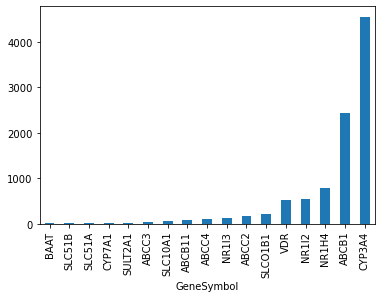

In [14]:
assays_aop.groupby('GeneSymbol')['AID'].nunique().sort_values().plot(kind='bar')

### Identifying Assay Mechanism

Split assays into whether they are either agonists/activators or antagonist/inhibitors

In [15]:
q1 = '((`BioAssay Name`.str.contains("agonist", case=False)) and not (`BioAssay Name`.str.contains("antagonist", case=False)))'
q2 = '((`BioAssay Name`.str.contains("activat", case=False)) and not (`BioAssay Name`.str.contains("inactiv", case=False)))'
q3 = 'not (`BioAssay Name`.str.contains("inhibit", case=False))'
q = q1 + ' or ' + q2 + ' and ' + q3
agonists = assays_aop.query(q)

In [16]:
q1 = '(`BioAssay Name`.str.contains("inhibit", case=False))'
q2 = '(`BioAssay Name`.str.contains("antagon", case=False))'
q = q1 + ' or ' + q2
antagonists = assays_aop.query(q)

In [17]:
agonists.AID.nunique()

1373

In [18]:
antagonists.AID.nunique()

5882

In [19]:
antagonists.GeneSymbol.nunique()

14

In [20]:
agonists.GeneSymbol.nunique()

7

In [21]:
agonists['Target'] = agonists.GeneSymbol.astype('str') + '_UP'
antagonists['Target'] = antagonists.GeneSymbol.astype('str') + '_DOWN'
pathway_frame = pd.concat([agonists, antagonists])
pathway_frame.head()

/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,AID,Gene IDs,BioAssay Name,GeneSymbol,Target
95,317950,5243,Activation of human P-glycoprotein ATPase in C...,ABCB1,ABCB1_UP
97,321880,5243,Activation of human Pgp ATPase in human Caco-2...,ABCB1,ABCB1_UP
112,330503,5243,Activation of human P-gp ATPase in human Caco-...,ABCB1,ABCB1_UP
202,386353,5243,Activation of ATPase activity of human histidi...,ABCB1,ABCB1_UP
203,386354,5243,Activation of ATPase activity of human histidi...,ABCB1,ABCB1_UP


### Profiling

#### Binary responses

In [22]:
target_aids = pathway_frame.AID.unique().tolist()

In [23]:
profile = pd.read_sql_query('select PUBCHEM_AID AS AID, CAST(PUBCHEM_CID AS INT) AS CID , PUBCHEM_ACTIVITY_OUTCOME AS ACTIVITY  from concise WHERE PUBCHEM_CID NOT NULL and AID in ({})'.format(','.join(map(str, target_aids))), con="sqlite:////Volumes/TOSHIBA EXT/data/pubchem/pubchem_concise.db")

In [24]:
profile_target = profile.merge(pathway_frame, how='left')
profile_target.head()

,AID,CID,ACTIVITY,Gene IDs,BioAssay Name,GeneSymbol,Target
0,442229,44605616,Active,1576,Inhibition of CYP3A4,CYP3A4,CYP3A4_DOWN
1,442229,44605617,Active,1576,Inhibition of CYP3A4,CYP3A4,CYP3A4_DOWN
2,443709,16045493,Active,1576,Inhibition of CYP3A4,CYP3A4,CYP3A4_DOWN
3,443868,45139236,Unspecified,1576,Inhibition of CYP3A4 at 3 uM after 30 mins,CYP3A4,CYP3A4_DOWN
4,443868,45485915,Unspecified,1576,Inhibition of CYP3A4 at 3 uM after 30 mins,CYP3A4,CYP3A4_DOWN


In [25]:
cid_counts = profile_target.groupby(['CID', 'Target'])['ACTIVITY'].apply(lambda x: (x=='Active').sum())
cid_counts

CID        Target     
4          CYP3A4_DOWN    0
           NR1H4_DOWN     0
           NR1H4_UP       0
           NR1I2_UP       0
           NR1I3_DOWN     0
                         ..
162676863  CYP3A4_DOWN    1
162677134  ABCB1_DOWN     0
162677159  CYP3A4_DOWN    0
162677188  NR1H4_UP       2
162677356  CYP3A4_DOWN    0
Name: ACTIVITY, Length: 480243, dtype: int64

In [26]:
cid_counts = cid_counts.reset_index()
cid_counts.head()

,CID,Target,ACTIVITY
0,4,CYP3A4_DOWN,0
1,4,NR1H4_DOWN,0
2,4,NR1H4_UP,0
3,4,NR1I2_UP,0
4,4,NR1I3_DOWN,0


In [27]:
cid_x_targets = cid_counts.pivot(index='CID', columns='Target', values='ACTIVITY')
cid_x_targets.head()

Target,ABCB11_DOWN,ABCB1_DOWN,ABCB1_UP,ABCC2_DOWN,ABCC3_DOWN,ABCC4_DOWN,CYP3A4_DOWN,CYP3A4_UP,CYP7A1_DOWN,NR1H4_DOWN,NR1H4_UP,NR1I2_DOWN,NR1I2_UP,NR1I3_DOWN,NR1I3_UP,SLC10A1_DOWN,SLCO1B1_DOWN,VDR_DOWN,VDR_UP
CID,,,,,,,,,,,,,,,,,,,
4,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
6,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.0,0.0,NaN,2.0,2.0,0.0,NaN,NaN,2.0,0.0
11,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
13,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN


In [28]:
cid_x_targets_norm = (cid_x_targets / cid_x_targets.max())
cid_x_targets_norm.fillna(0).mean(1).sort_values(ascending=False)

CID
5284373      0.242174
3238389      0.178235
135398735    0.128091
5339         0.124591
2520         0.123696
               ...   
7998995      0.000000
7999036      0.000000
7999043      0.000000
7999054      0.000000
4            0.000000
Length: 419562, dtype: float64

#### Dose Response Assays

In [29]:
aid_list = [str(aid) for aid in target_aids]

aid_string = ", ".join(map(str, aid_list))
aid_query = f'({aid_string})'

actives_query = 'SELECT c.PUBCHEM_CID as CID, c.PUBCHEM_AID as AID, c.PUBCHEM_SID as SID ' \
                'FROM concise c ' \
                'WHERE c.PUBCHEM_AID in {} AND c.PUBCHEM_ACTIVITY_OUTCOME == "Active" AND ' \
                'c.PUBCHEM_CID is not null AND c.PUBCHEM_SID is not null'.format(aid_query)

active_cmps = pd.read_sql_query(actives_query, con=config.Config.DB_URI)
active_cmps['SID'] = active_cmps['SID'].astype(int)

sid_list = [str(sid)for sid in active_cmps.SID]

sid_string = ", ".join(map(str, sid_list))
sid_query = f'({sid_string})'

hill_params_query = 'SELECT  SID, AID, AC50, TOP, SLOPE, MSE ' \
                    'FROM hill_models ' \
                    'WHERE AID in {} AND SID in {} '.format(aid_query, sid_query)

hill_params = pd.read_sql_query(hill_params_query, con=config.Config.DB_URI)

# this merge is necessary because
# the former query gathers all data
# for all sid and aid that have any active cmps
# not just the pairs of active sid, aid
# could be solved by a SQLite join, but
# right now takes too long
hill_merged = pd.merge(hill_params, active_cmps[['SID', 'CID', 'AID']].drop_duplicates(['SID', 'CID', 'AID']), on=['SID', 'AID'])
print(hill_merged.head())

      SID     AID        AC50         TOP     SLOPE           MSE        CID
0  842408  504847  105.442945 -120.000000  8.000000  1.218814e-01     644675
1  842823  504847   59.544619  -65.618356  7.969804  1.667165e-09  135450609
2  843190  504847   22.986003  -75.974782  1.246930  6.912329e+00      70863
3  843534  602199    9.968555  -93.127690  7.998962  3.487031e-08    6603145
4  843534  602200    4.534788  -98.670421  2.198862  8.087151e-02    6603145


In [30]:
hill_merged.AID.nunique()

26

In [31]:
pathway_frame[pathway_frame.AID.isin(hill_merged.AID.unique())].Target.unique()

array(['CYP3A4_UP', 'VDR_UP', 'NR1I2_UP', 'NR1I3_UP', 'NR1H4_UP',
       'ABCB1_DOWN', 'CYP3A4_DOWN', 'VDR_DOWN', 'NR1I3_DOWN',
       'NR1H4_DOWN'], dtype=object)

In [32]:
hill_merged = hill_merged.merge(pathway_frame[['AID', 'Target']].drop_duplicates())
hill_merged.head()

,SID,AID,AC50,TOP,SLOPE,MSE,CID,Target
0,842408,504847,105.442945,-120.000000,8.000000,1.218814e-01,644675,VDR_DOWN
1,842823,504847,59.544619,-65.618356,7.969804,1.667165e-09,135450609,VDR_DOWN
2,843190,504847,22.986003,-75.974782,1.246930,6.912329e+00,70863,VDR_DOWN
3,844303,504847,66.547961,-74.743820,7.897751,4.766213e-10,646623,VDR_DOWN
4,844835,504847,114.213096,-120.000000,8.000000,3.412183e-02,647166,VDR_DOWN


#### AOP Model

In [33]:
from curve_fitting import hill_curve
from curvep import curveP, CONCLIST

xs = np.asarray(CONCLIST)

dfs = []

for (aid, cid), params in hill_merged.groupby(['AID', 'CID']):

    params = params[params.MSE == params.MSE.min()]

    if params.shape[0] > 1:
        print(params)
    if params.empty:
        continue
    curve = hill_curve(xs, params.AC50.iloc[0], params.TOP.iloc[0], params.SLOPE.iloc[0])
    df = pd.DataFrame()
    df['log(Concentration)'] = np.log10(xs)
    df['Response'] = curve
    df['AID'] = aid
    df['CID'] = cid
    df['Target'] = params.Target.iloc[0]
    dfs.append(df)
dfs = pd.concat(dfs)

             SID      AID       AC50         TOP  SLOPE       MSE    CID  \
12633  144209922  1346982  29.132675 -102.205456    8.0  1.662619  14425   
13489  144213796  1346982  29.132675 -102.205456    8.0  1.662619  14425   

         Target  
12633  NR1I2_UP  
13489  NR1I2_UP  
             SID      AID       AC50         TOP  SLOPE       MSE    CID  \
12533  144209523  1346982  29.132675 -102.205456    8.0  1.662619  22772   
12918  144211375  1346982  29.132675 -102.205456    8.0  1.662619  22772   

         Target  
12533  NR1I2_UP  
12918  NR1I2_UP  


In [34]:
genes_aids = hill_merged.copy()
genes_aids['Pathway'] = WIKI_PATHWAY

F_matrix = pd.DataFrame(index=hill_merged.AID.unique().astype(int), columns=[WIKI_PATHWAY])

for aop, aop_data in genes_aids.groupby('Pathway'):
    for aid in aop_data.AID.unique():
        F_matrix.loc[aid, aop] = 1
F_matrix = F_matrix.fillna(0)
F_matrix


,WP2289
504847,1
602199,1
602200,1
602201,1
602202,1
884,1
885,1
720659,1
588526,1
588541,1


In [35]:
frames = {}
cids = []


for cid, d in dfs.groupby('CID'):
    training_wide = d.pivot(columns='log(Concentration)', index='AID', values='Response')
    # fill missing data AIDs
    training_wide = training_wide.reindex(F_matrix.index).fillna(0)
    frames[cid] = training_wide
    cids.append(cid)

In [36]:
cr_responses = np.stack([frames[cas].values for cas in cids], axis=2)

In [37]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

In [38]:
EPOCHS = 750
STEPS = 100
INITIAL_LR = 1
GAMMA = 0.5

F = torch.tensor(F_matrix.values, dtype=torch.float)
R = torch.tensor(np.random.random(size=(F.shape[1], cr_responses.shape[1], cr_responses.shape[2])),
                 dtype=torch.float, requires_grad=True)

# R = torch.tensor(torch.clamp(R, min=0, max=1), requires_grad=True)


y = torch.tensor(cr_responses)

optimizer = optim.Adam([R], lr=INITIAL_LR)
#scheduler = StepLR(optimizer, step_size=STEPS, gamma=0.9)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=50)

In [39]:
losses = np.array([])

for epoch in range(EPOCHS):
    # model is y = FR
    optimizer.zero_grad()
    #R = torch.clamp(R, min=0, max=1)
    model = torch.tensordot(F, R, dims=([1], [0]))


    ss_term = torch.mean(torch.square(model - y))

    x = torch.sum(R)
    penalty_term = x ** 10 / (x ** 10 + 0.5 ** 10)

    loss = ss_term + penalty_term
    loss = ss_term

    loss.backward()
    optimizer.step()
    losses = np.append(losses, loss.detach().numpy())
    #     if losses[-50:].var() < 0.1 and epoch>10:
    #         #print("Reducing LR...")
    #         for g in optimizer.param_groups:
    #             g['lr'] = g['lr']*GAMMA
    scheduler.step(loss)
    if epoch % STEPS == 0:
        print(loss)
        print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))

tensor(47.6560, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-0 lr: 1
tensor(44.4192, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-100 lr: 1
tensor(44.4191, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-200 lr: 0.010000000000000002
tensor(44.4191, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-300 lr: 0.00010000000000000003
tensor(44.4191, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-400 lr: 1.0000000000000004e-06
tensor(44.4191, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-500 lr: 1.0000000000000005e-08
tensor(44.4191, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-600 lr: 1.0000000000000005e-08
tensor(44.4191, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-700 lr: 1.0000000000000005e-08


In [40]:
from curve_fitting import auc_score

scores = R.detach().numpy()

cmp_score_dic = {}

for i, casnumber in enumerate(cids):
    cmp_r_scores = pd.DataFrame(scores[:, :, i], index=F_matrix.columns, columns=np.log10(xs))
    cmp_auc_scores = auc_score(cmp_r_scores)
    cmp_score_dic[casnumber] = (cmp_r_scores, cmp_auc_scores)

In [41]:
d = [cmp_score_dic[cas][1] for cas in cids]

score_frame = pd.DataFrame(d, index=cids)

In [42]:
score_frame_norm = score_frame.divide(score_frame.max()).fillna(0)

scores_norm = scores.copy()

for r in range(scores_norm.shape[0]):
    scaler = scores[r, :, :].max()
    if scaler != 0:
        scores_norm[r, :, :] = scores_norm[r, :, :]*1/scaler

cmp_score_norm_dic = {}

for i, casnumber in enumerate(cids):
    cmp_r_scores = pd.DataFrame(scores_norm[:, :, i], index=F_matrix.columns, columns=np.log10(xs))
    cmp_score_norm_dic[casnumber] = cmp_r_scores

In [43]:
score_frame_norm.head()

,WP2289
6,-0.385755
177,0.019746
190,0.026798
204,-0.062412
289,0.060649


In [44]:
score_frame_norm.sort_values(WIKI_PATHWAY)

,WP2289
68589,-1.736601
456201,-1.694288
16682730,-1.593441
15910,-1.555007
4641,-1.369535
...,...
44640183,0.787377
44629742,0.795134
44630540,0.824401
5288783,0.990127


,CleanedInChI,CID,NAME,H_HT_class,H_CC_class,H_MF_class,H_MFHB_class,H_MFHC_class,PC_HT_class,PC_CC_class,...,PC_CCHBdl500_class,PC_MFHCdl500_class,PC_MFHBdl500_class,H_CCHB_class,H_CCHC_class,CAS,Original-Mol-ID,Dataset-ID,ID,ROMol
0,"InChI=1S/C10Cl10/c11-1-2(12)6(16)9(19,5(1)15)1...",16686.0,nan,nan,nan,nan,nan,nan,1.0,0.0,...,nan,nan,nan,nan,nan,2227-17-0,Mol-3576,HepatoBinary-Mol-0,,
1,"InChI=1S/C10Cl10O/c11-2-1(21)3(12)6(15)4(2,13)...",299.0,chlordecone,1.0,nan,nan,nan,nan,1.0,0.0,...,nan,nan,nan,nan,nan,143-50-0,Mol-396,HepatoBinary-Mol-1,,
2,"InChI=1S/C10Cl12/c11-1-2(12)7(17)4(14)3(13,5(1...",16945.0,nan,nan,nan,nan,nan,nan,1.0,0.0,...,nan,nan,nan,nan,nan,2385-85-5,Mol-3633,HepatoBinary-Mol-2,,
3,InChI=1S/C10H10Cl2O3/c11-7-3-4-9(8(12)6-7)15-5...,1489.0,nan,nan,nan,nan,nan,nan,1.0,nan,...,nan,nan,nan,nan,nan,94-82-6,Mol-2819,HepatoBinary-Mol-3,,
4,InChI=1S/C10H10N2O/c1-8-7-10(13)12(11-8)9-5-3-...,nan,nan,nan,nan,nan,nan,nan,1.0,nan,...,nan,nan,nan,nan,nan,89-25-8,Mol-2486,HepatoBinary-Mol-4,,

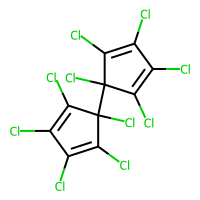
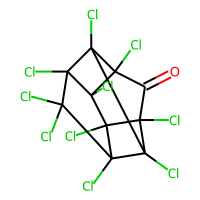
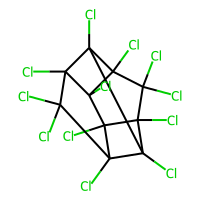
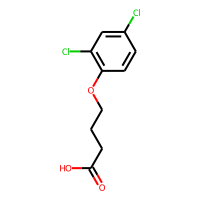
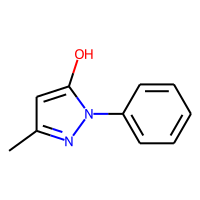

In [47]:
from rdkit.Chem import PandasTools

sdfile = '/Volumes/TOSHIBA EXT/data/Yitao/Public_compounds_heptox_classification_curated_CID.sdf'

hepatotoxicity = PandasTools.LoadSDF(sdfile)

hepatotoxicity.head()

In [48]:
hepatotoxicity = hepatotoxicity.replace('nan', np.nan)

In [54]:
hepatotoxicity = hepatotoxicity[hepatotoxicity.CID.notnull()]
hepatotoxicity['CID'] = hepatotoxicity.CID.astype(float).astype(int)
hepatotoxicity = hepatotoxicity.set_index('CID')

,CleanedInChI,NAME,H_HT_class,H_CC_class,H_MF_class,H_MFHB_class,H_MFHC_class,PC_HT_class,PC_CC_class,PC_MF_class,...,PC_CCHBdl500_class,PC_MFHCdl500_class,PC_MFHBdl500_class,H_CCHB_class,H_CCHC_class,CAS,Original-Mol-ID,Dataset-ID,ID,ROMol
CID,,,,,,,,,,,,,,,,,,,,,
16686,"InChI=1S/C10Cl10/c11-1-2(12)6(16)9(19,5(1)15)1...",NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,2227-17-0,Mol-3576,HepatoBinary-Mol-0,,
299,"InChI=1S/C10Cl10O/c11-2-1(21)3(12)6(15)4(2,13)...",chlordecone,1.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,143-50-0,Mol-396,HepatoBinary-Mol-1,,
16945,"InChI=1S/C10Cl12/c11-1-2(12)7(17)4(14)3(13,5(1...",NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,2385-85-5,Mol-3633,HepatoBinary-Mol-2,,
1489,InChI=1S/C10H10Cl2O3/c11-7-3-4-9(8(12)6-7)15-5...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,94-82-6,Mol-2819,HepatoBinary-Mol-3,,
5215,"InChI=1S/C10H10N4O2S/c11-8-2-4-9(5-3-8)17(15,1...",sulfadiazine;sulfadiazine sodium,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,Mol-1740,HepatoBinary-Mol-5,,

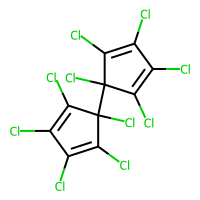
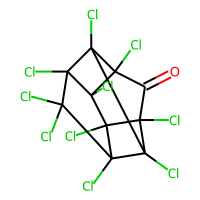
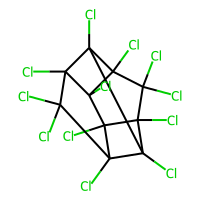
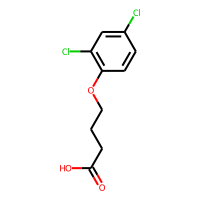
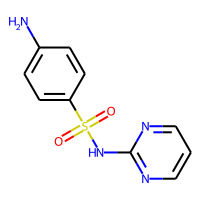

In [55]:
hepatotoxicity.head()

In [60]:
d = score_frame_norm.join(hepatotoxicity[['H_HT_class']]).dropna()

In [63]:
d.sort_values('WP2289')

,WP2289,H_HT_class
4641,-1.369535,1.0
4189,-0.975317,1.0
71360,-0.922426,1.0
5455,-0.915021,0.0
6855,-0.845557,0.0
...,...,...
4078,0.399506,1.0
2750,0.423836,1.0
4615,0.427715,1.0
134018,0.443583,1.0


In [68]:
d.H_HT_class.astype(float).sum() / d.H_HT_class.shape[0]

0.7323529411764705

In [75]:
d=d.sort_values(WIKI_PATHWAY)
d['Rank'] = list(range(1, d.shape[0]+1))

<AxesSubplot:xlabel='WP2289', ylabel='Rank'>

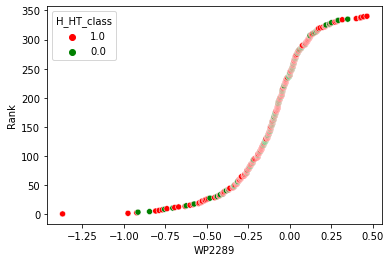

In [80]:
import seaborn as sns
sns.scatterplot(data=d.sort_values(WIKI_PATHWAY), x=WIKI_PATHWAY, y='Rank', hue='H_HT_class', palette={'1.0': 'red', '0.0':'green'})

In [ ]:
# Try to build this heirarchically
# e.g., assays -> receptor
# e.g., receptor -> pathways
# e.g., pathways -> toxicity
# try with Css values

In [103]:
css = pd.read_csv('../data/css.csv')
css.columns = ['cas', 'css', 'cid']
css = css[['css', 'cid']].set_index('cid')

In [104]:
css

,css
cid,
980,0.821415
7500,2.534387
7501,0.493075
4101,7.893905
13878,5.111172
...,...
7456,0.196014
7471,1.561674
7473,0.412917


In [107]:
d.join(css, how='inner').sort_values(WIKI_PATHWAY, ascending=False)

,WP2289,H_HT_class,Rank,css
4115,0.463681,1.0,340,6.306697
40326,0.271509,1.0,330,0.649849
4632,0.239422,0.0,327,5.270728
16850,0.217913,0.0,325,25.995960
2812,0.212623,1.0,323,0.952820
...,...,...,...,...
3598,-0.576516,0.0,18,9557.713371
3749,-0.601551,1.0,16,1.115540
4004,-0.705571,0.0,11,0.014547
4011,-0.769394,1.0,8,45.935177


In [110]:
d.sort_values(WIKI_PATHWAY, ascending=False)

,WP2289,H_HT_class,Rank
4115,0.463681,1.0,340
134018,0.443583,1.0,339
4615,0.427715,1.0,338
2750,0.423836,1.0,337
4078,0.399506,1.0,336
...,...,...,...
6855,-0.845557,0.0,5
5455,-0.915021,0.0,4
71360,-0.922426,1.0,3
4189,-0.975317,1.0,2


In [112]:
hill_merged.query("CID == 134018")

,SID,AID,AC50,TOP,SLOPE,MSE,CID,Target
13706,170465220,1346982,0.050000,53.365200,1.617874,55.562581,134018,NR1I2_UP
17108,170465220,1224839,0.036201,35.485006,2.224077,3.723844,134018,NR1I3_UP
